<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/kaggle/input/magic-gamma-telescope/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
data.to_csv('MAGIC Gamma Telescope.csv', index=False)

# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

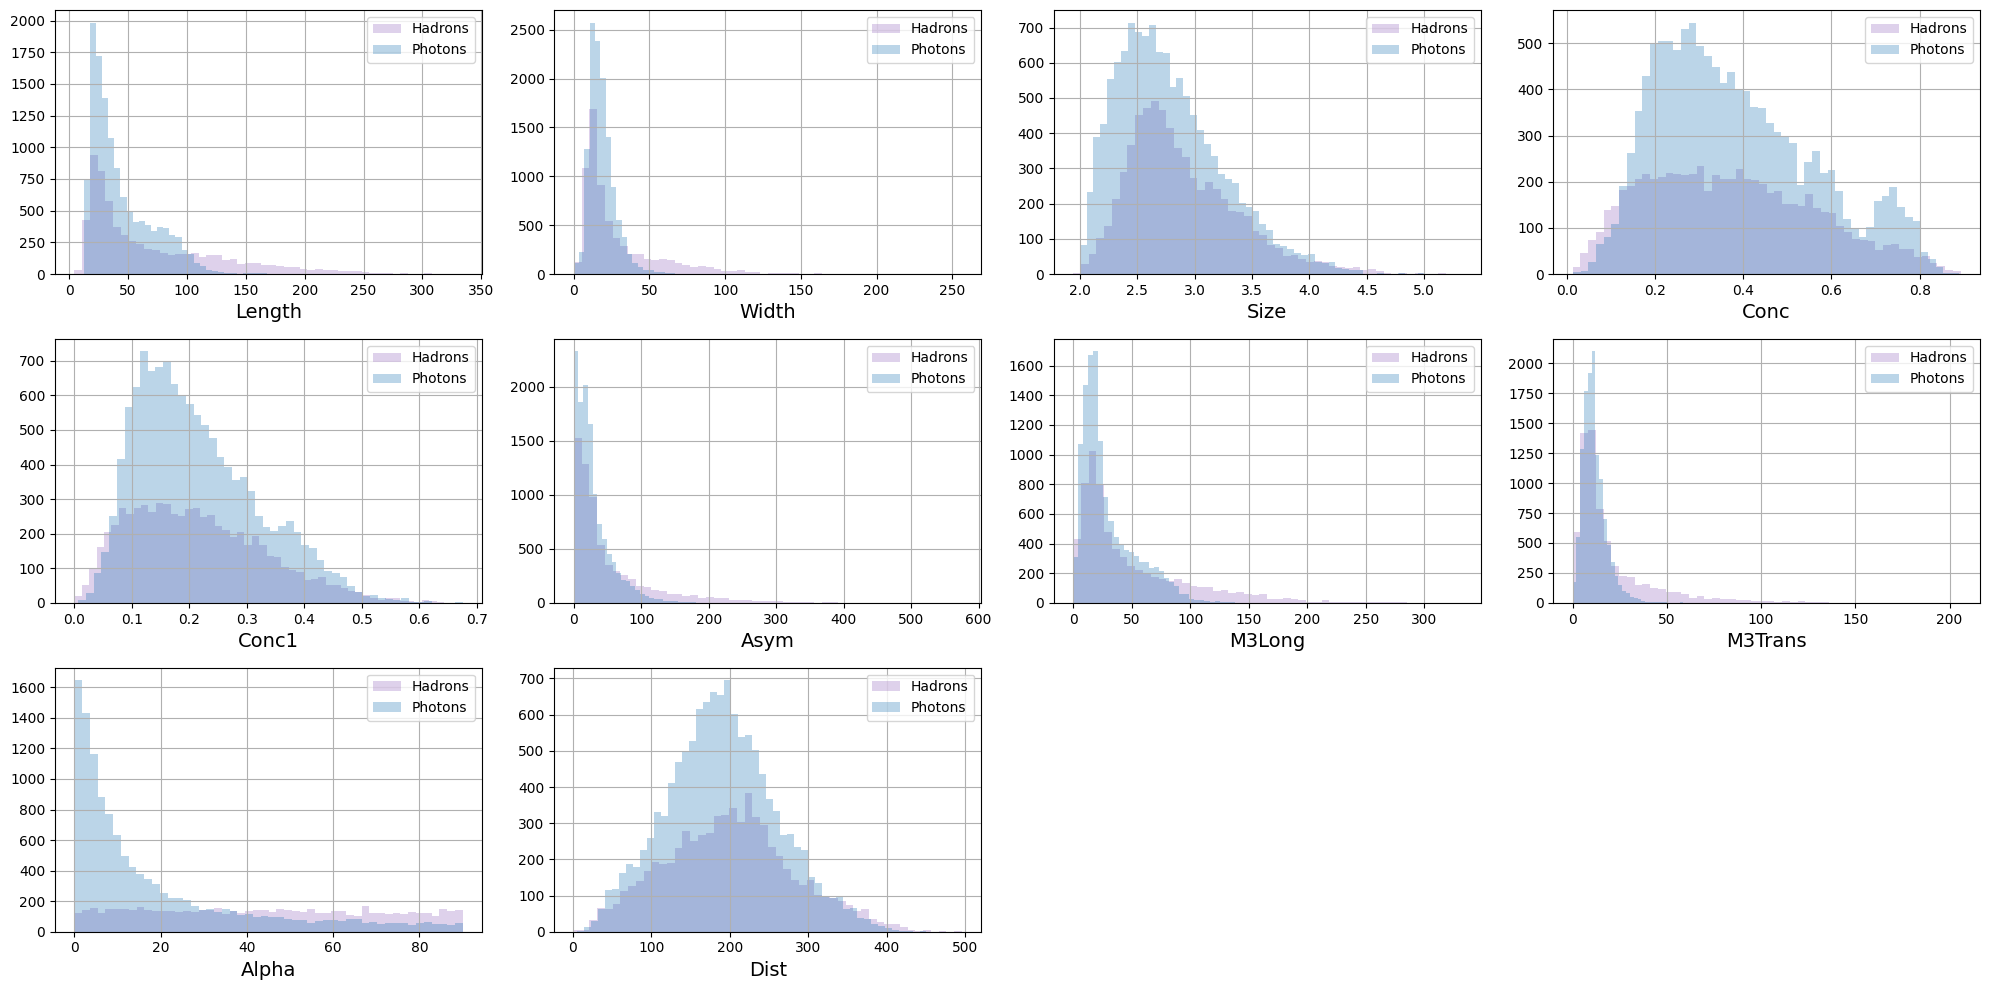

In [9]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [10]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

In [11]:
np.unique(y_train)

array([0., 1.])

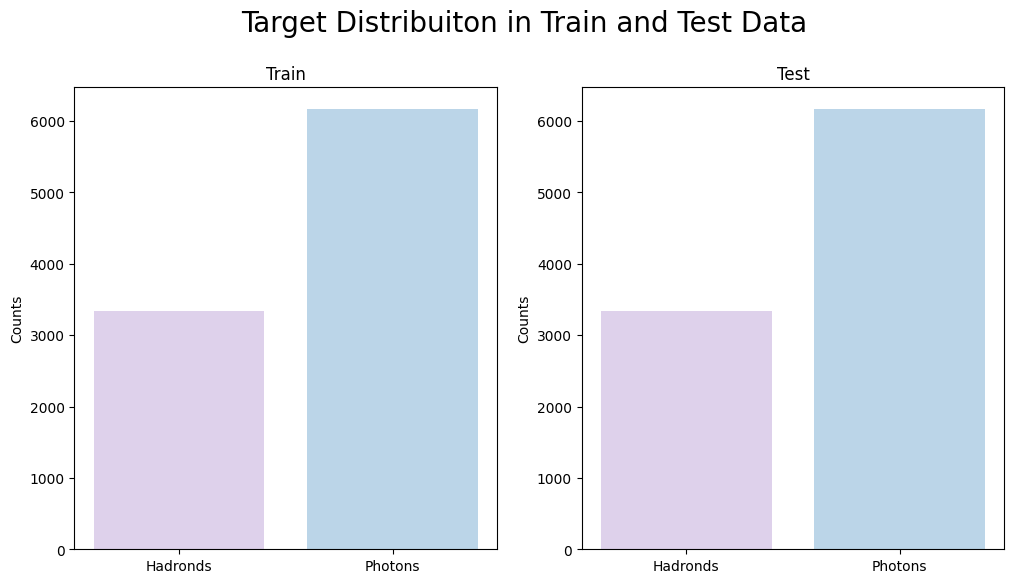

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

fig.suptitle('Target Distribuiton in Train and Test Data', fontsize=20, y=1.01)

ax1.bar(['Hadronds', 'Photons'], [np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1)], alpha=0.3, color = ["C4", "C0"])
ax1.set_title('Train')
ax1.set_ylabel('Counts')

ax2.bar(['Hadronds', 'Photons'], [np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1)], alpha=0.3, color = ["C4", "C0"])
ax2.set_title('Test')
ax2.set_ylabel('Counts')

plt.show()

Ну вся выборка делится пополам, так ещё и stratify по таргету сделан, поэтому количество объектов каждого класса одинаково.

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [13]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)

X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

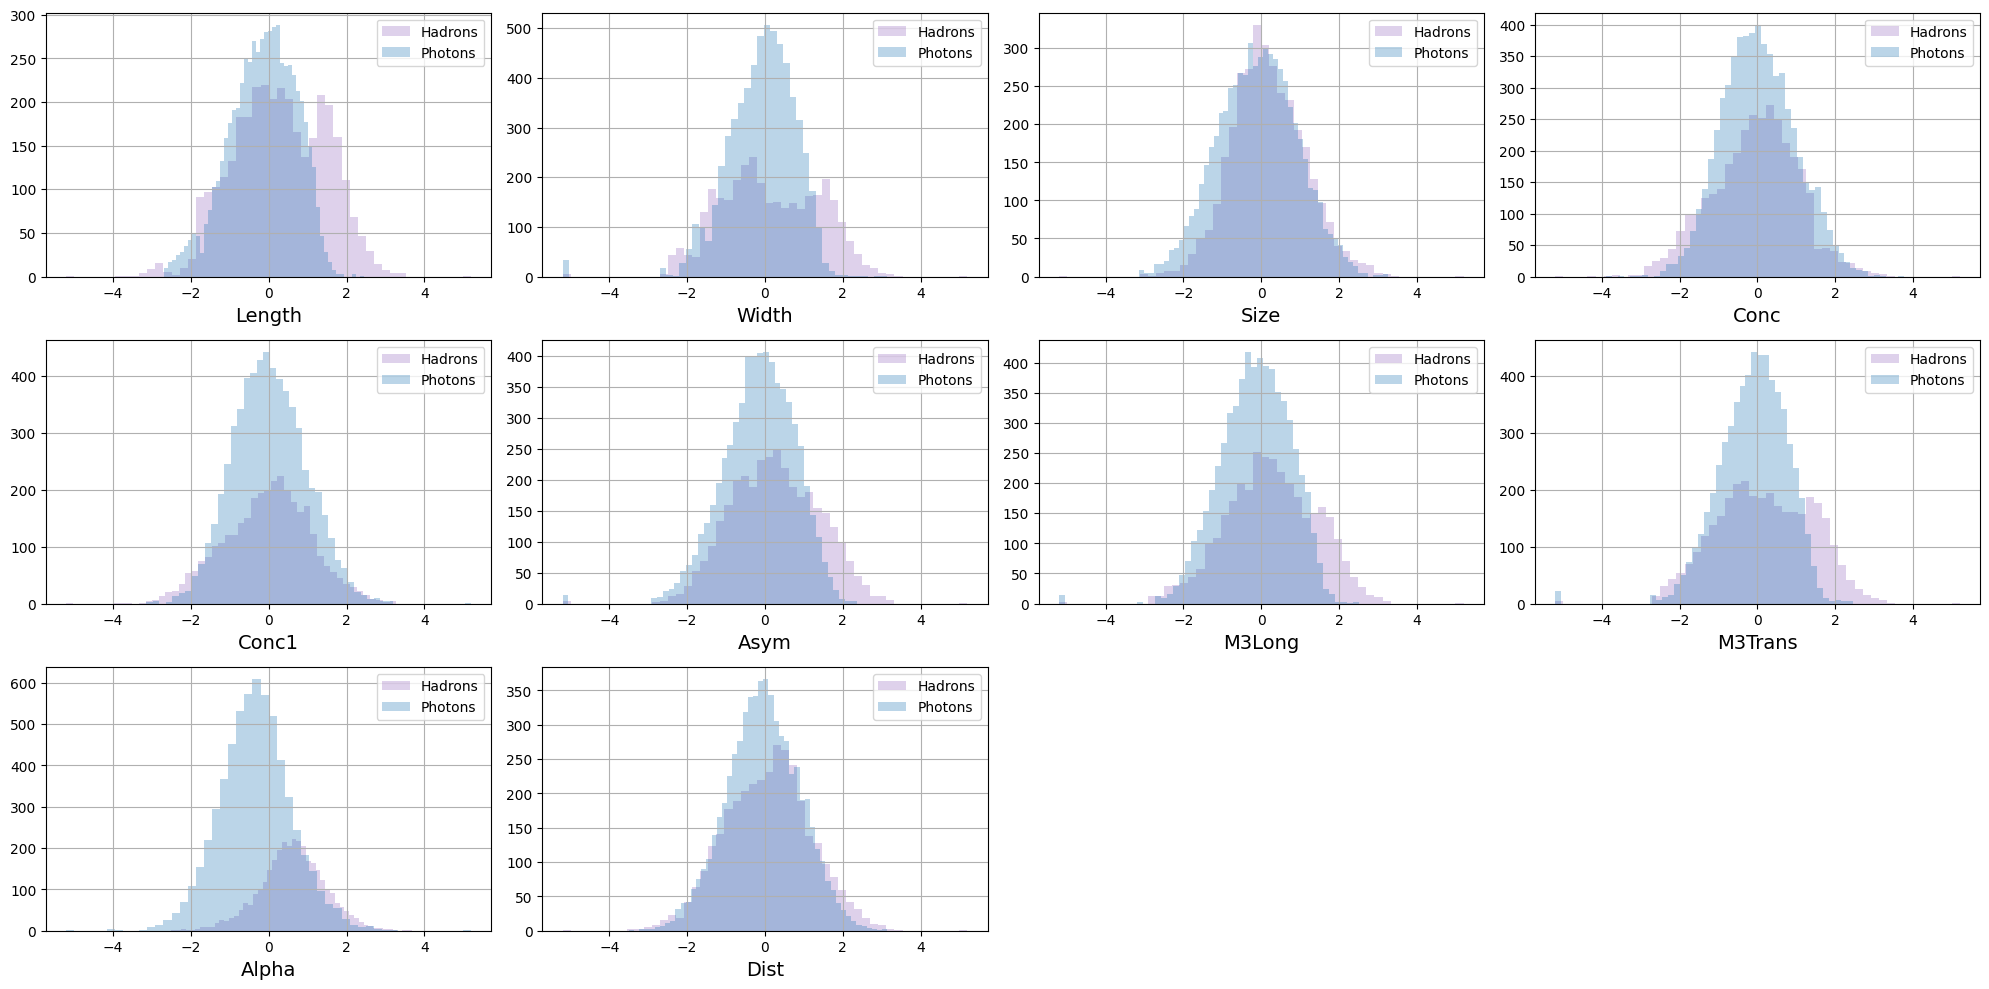

In [14]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

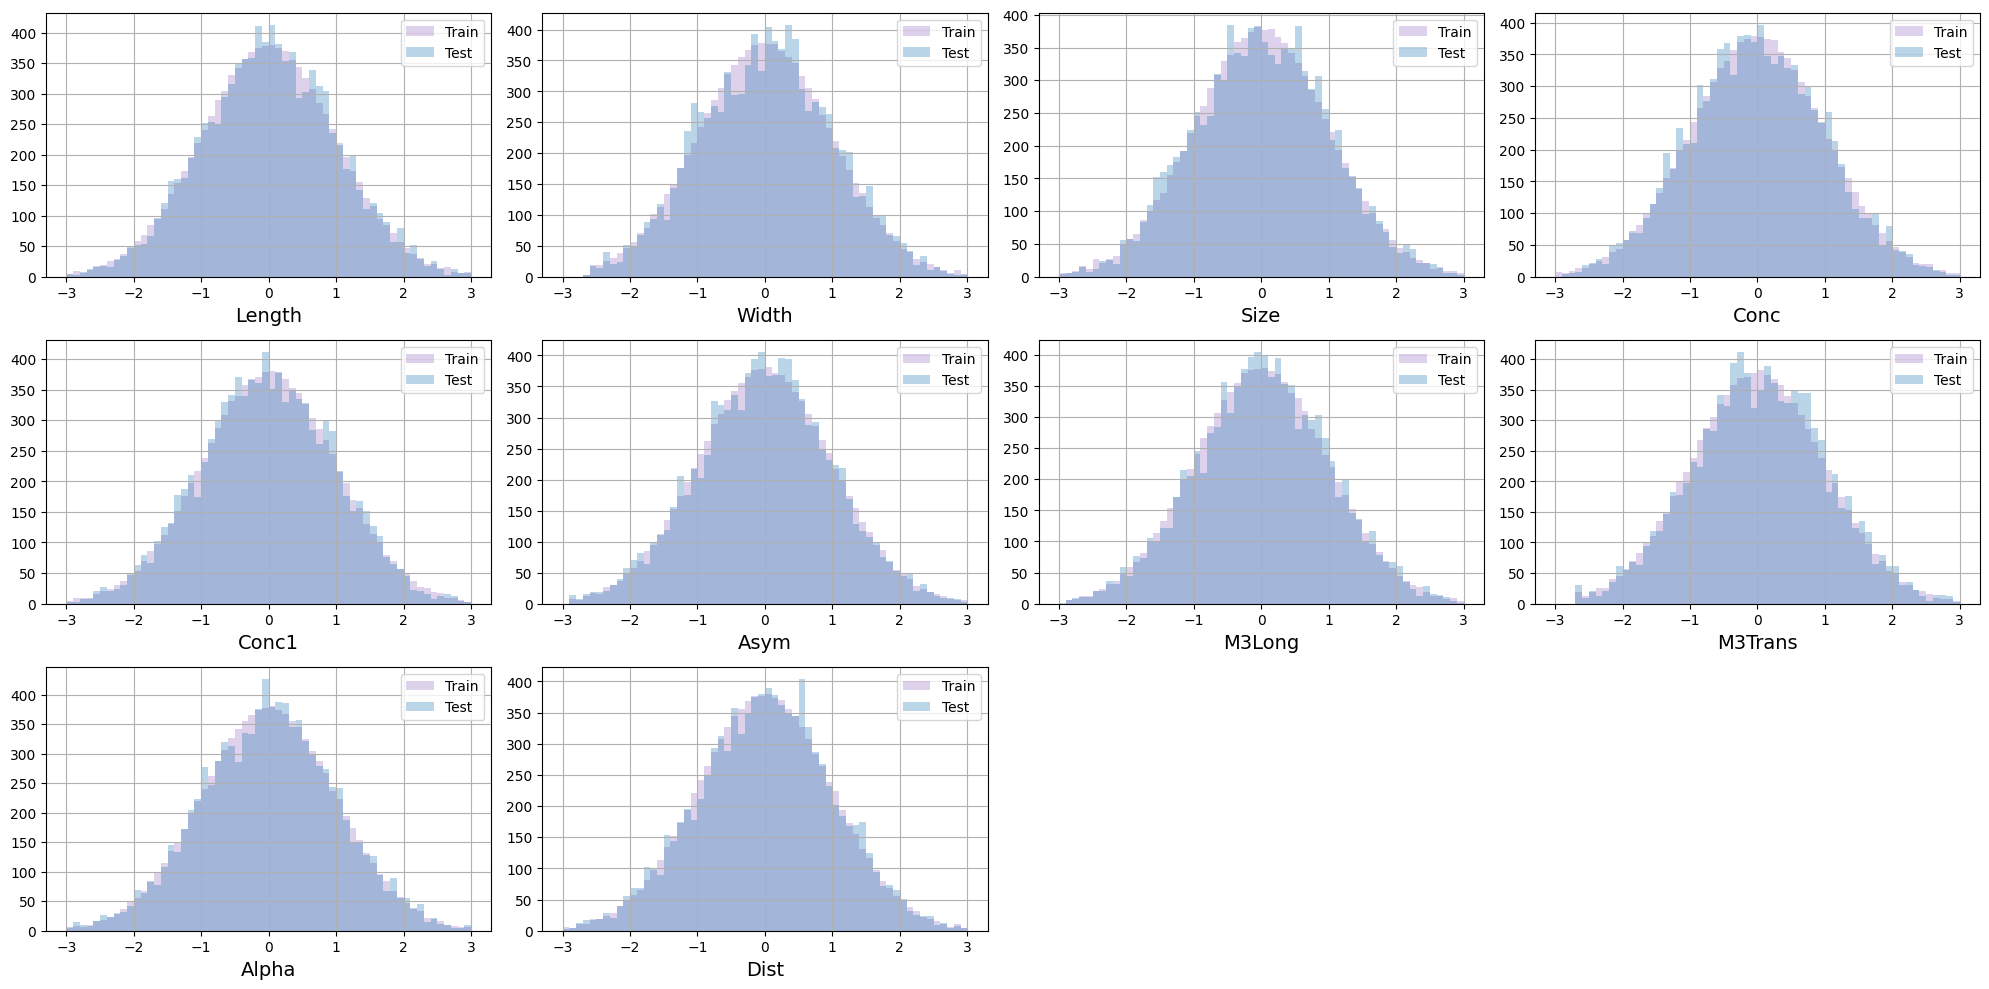

In [15]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [18]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )

        self.out = nn.Linear(100, n_outputs) 

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)      
        
        return self.out(self.fc2(self.fc1(zy)))

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [19]:
def generate(generator, y, latent_dim):

    Z_noise = np.random.randn(y.shape[0], latent_dim)
    X_fake = generator(torch.tensor(Z_noise).to(DEVICE).float(), torch.tensor(y).to(DEVICE).float()).detach().cpu().numpy()
    
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU()
        )

        self.out = nn.Linear(100,1) 

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.out(self.fc2(self.fc1(xy)))

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

def other_agent_score(X_real, y_real, X_fake, y_fake):

    data_real = np.concatenate((X_real, y_real), axis=1)
    data_fake = np.concatenate((X_fake, y_fake), axis=1)
    
    labels = np.concatenate((np.zeros(len(y_real)), np.ones(len(y_fake))), axis=0)

    data = np.vstack([data_real, data_fake])

    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

    lin_reg = LogisticRegression()
    lin_reg.fit(data_train, labels_train)
    lin_reg_score = accuracy_score(labels_test, lin_reg.predict(data_test))
    
    boosting = XGBClassifier()
    boosting.fit(data_train, labels_train)
    boosting_score = accuracy_score(labels_test, boosting.predict(data_test))
    
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Больше всего бы удовлетворило 0.5, потому что это эквивалентно рандомным предикатам, что означает, что фейковые и реальные данные неотличимы.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)
        
        self.generator.train(True)
        self.discriminator.train(True)
        self.loss_history = []

        for epoch in tqdm(range(self.n_epochs)):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                for _ in range(self.n_critic):
                    Z_noise = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                    fake_batch = self.generator(Z_noise, cond_batch).detach()
                    
                    real_loss_D = torch.mean(self.discriminator(real_batch, cond_batch))
                    fake_loss_D = torch.mean(self.discriminator(fake_batch, cond_batch))
                    loss_D = fake_loss_D - real_loss_D
                    
                    self.opt_disc.zero_grad()
                    loss_D.backward()
                    self.opt_disc.step()
                    
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                
                Z_noise = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                fake_batch = self.generator(Z_noise, cond_batch)
                
                real_loss_G = torch.mean(self.discriminator(real_batch, cond_batch))
                fake_loss_G = torch.mean(self.discriminator(fake_batch, cond_batch))
                loss_G = -(fake_loss_G - real_loss_G)
                
                self.opt_gen.zero_grad()
                loss_G.backward()
                self.opt_gen.step()
            
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(self.generator(torch.randn(len(X_real), self.latent_dim, device=DEVICE), y_cond), y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            
            X_sample_real = X_real[torch.randint(0, len(X_real), (1000,))]
            y_sample_real = y_cond[torch.randint(0, len(y_cond), (1000,))]
            Z_noise = torch.randn(1000, self.latent_dim, device=DEVICE)
            X_sample_fake = self.generator(Z_noise, y_sample_real)
            y_sample_fake = y_sample_real
            
            other_agent_score(X_sample_real.detach().cpu().numpy(), y_sample_real.detach().cpu().numpy(), X_sample_fake.detach().cpu().numpy(), y_sample_fake.detach().cpu().numpy())
        
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [23]:
import random
import os

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [24]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

Linear regression score: 0.532
Boosting score: 0.81
Linear regression score: 0.486
Boosting score: 0.762
Linear regression score: 0.526
Boosting score: 0.758
Linear regression score: 0.536
Boosting score: 0.74
Linear regression score: 0.516
Boosting score: 0.734
Linear regression score: 0.55
Boosting score: 0.734
Linear regression score: 0.524
Boosting score: 0.664
Linear regression score: 0.524
Boosting score: 0.662
Linear regression score: 0.576
Boosting score: 0.706
Linear regression score: 0.562
Boosting score: 0.722
Linear regression score: 0.518
Boosting score: 0.684
Linear regression score: 0.564
Boosting score: 0.692
Linear regression score: 0.568
Boosting score: 0.696
Linear regression score: 0.536
Boosting score: 0.708
Linear regression score: 0.572
Boosting score: 0.694
Linear regression score: 0.532
Boosting score: 0.68
Linear regression score: 0.576
Boosting score: 0.666
Linear regression score: 0.518
Boosting score: 0.718
Linear regression score: 0.542
Boosting score: 0.6

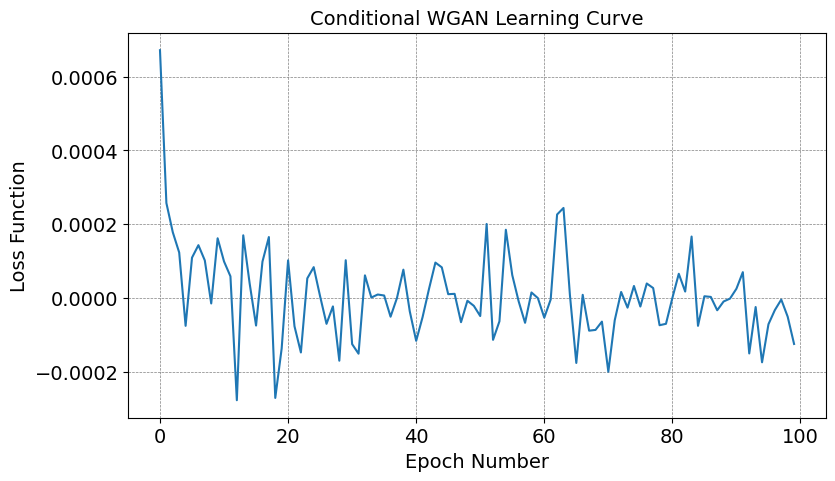

In [25]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [26]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

X_train = quantile_transformer.inverse_transform(X_train)
X_fake_train = quantile_transformer.inverse_transform(X_fake_train)

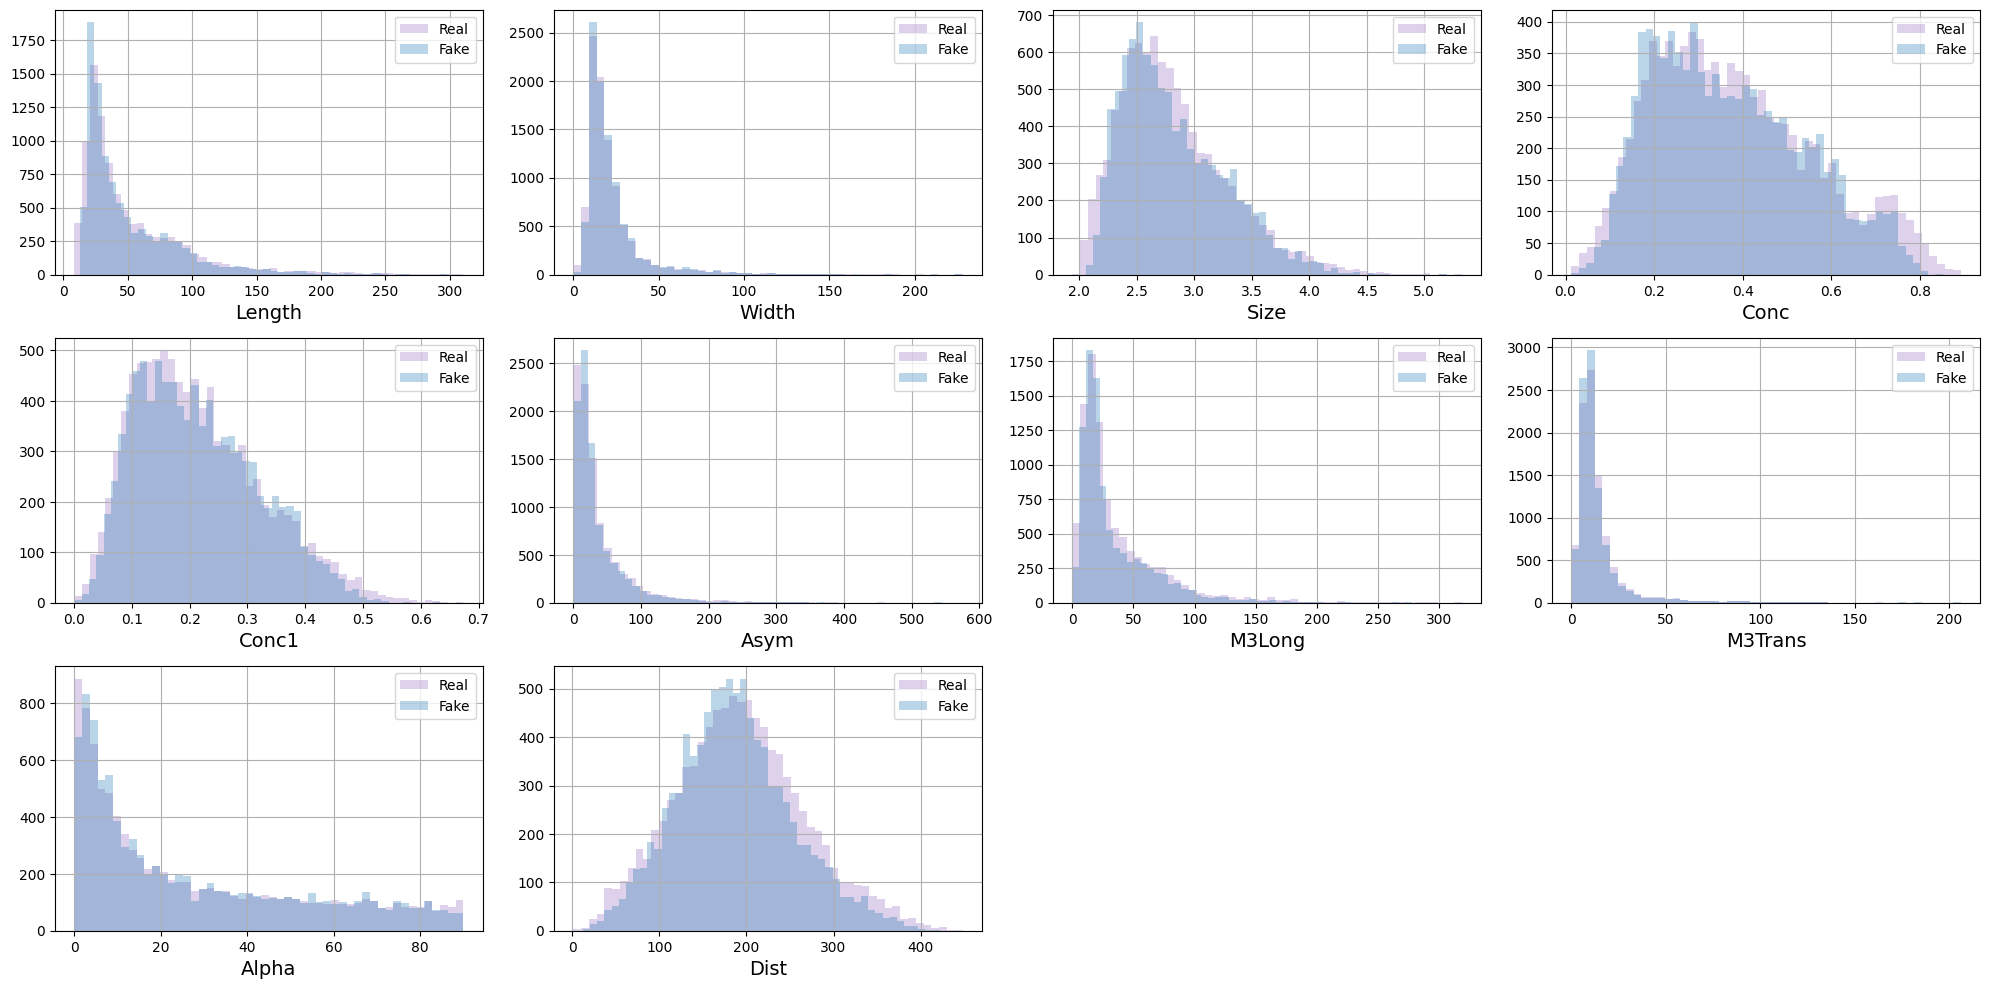

In [27]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [28]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

X_test = quantile_transformer.inverse_transform(X_test)
X_fake_test = quantile_transformer.inverse_transform(X_fake_test)

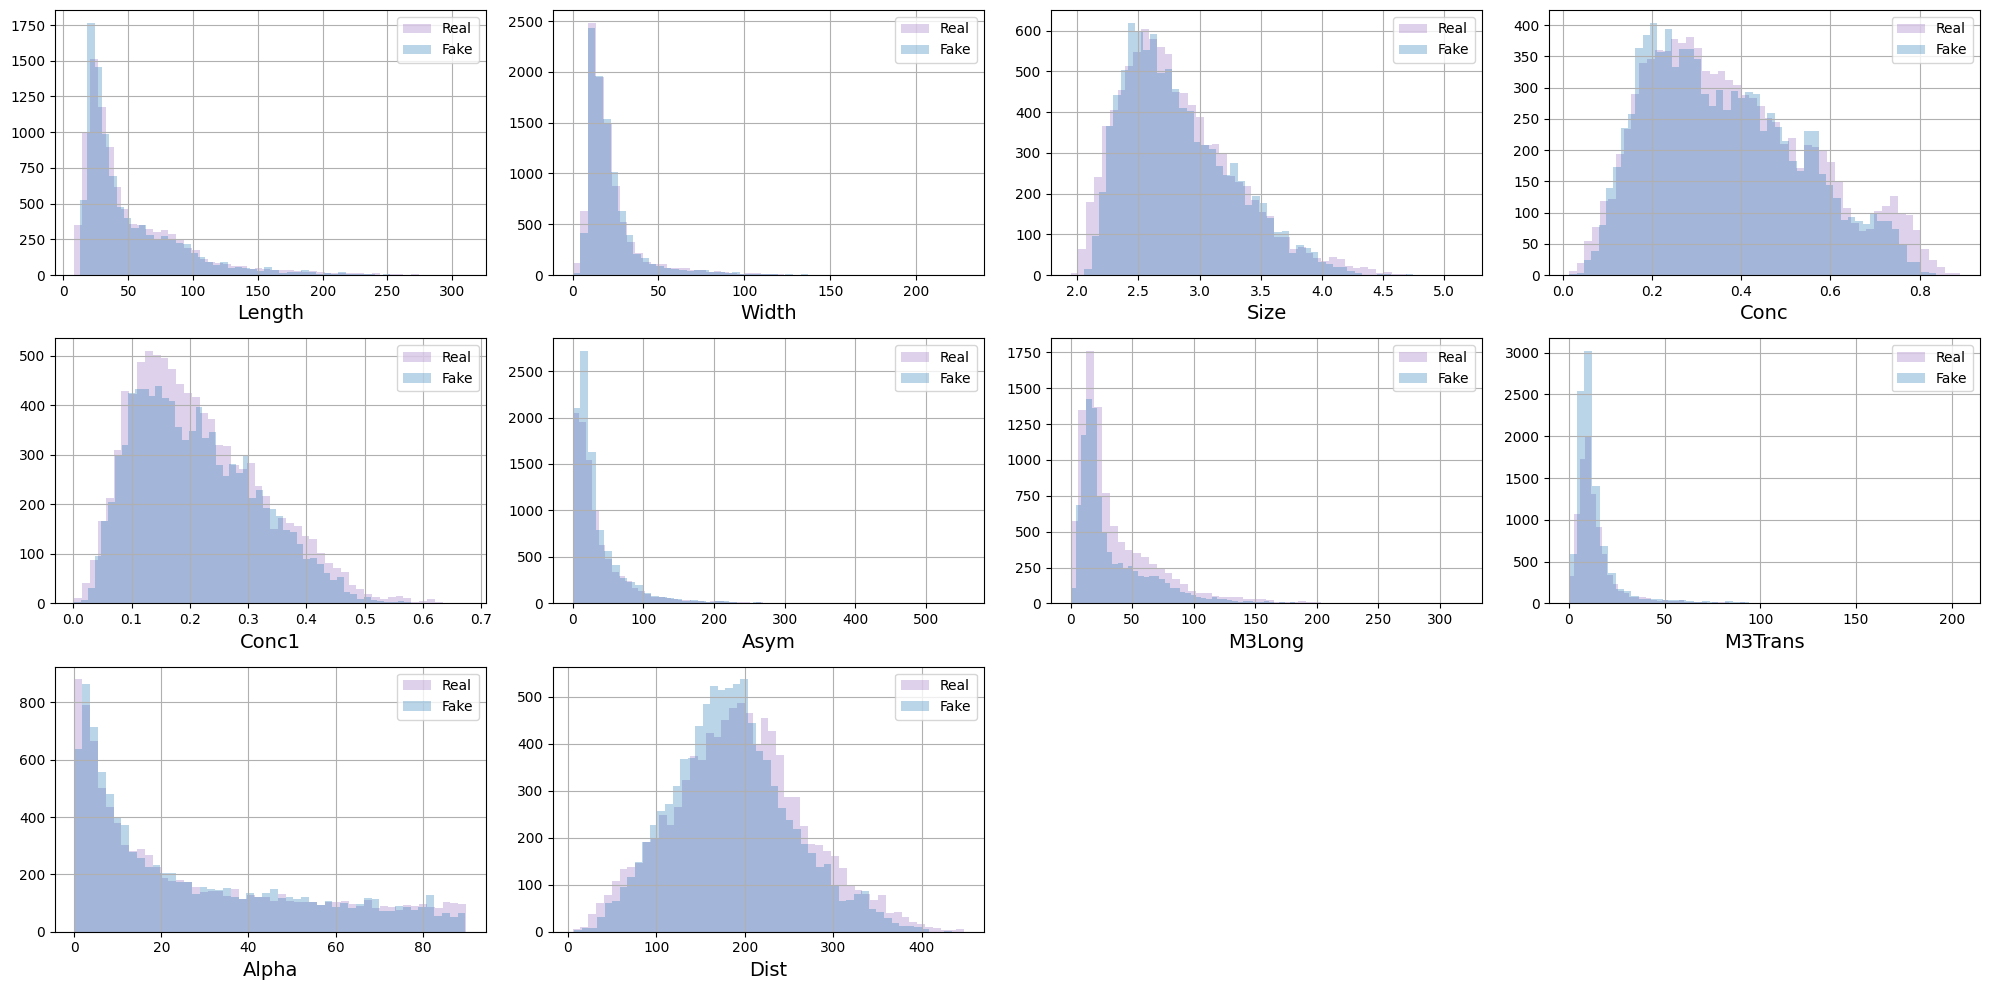

In [29]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы: 
- Похожи ли фейковые объекты на реальные? 
- Точно ли хорошая идея сравнивать их на глаз?


Нуу вроде похоже, но графикам распределений верить такая себе идея.

# Измерение качества генерации

Измерим сходство распределений классификатором.

In [30]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_test_pred = clf.predict(XX_test)

In [32]:
from sklearn.metrics import roc_auc_score, accuracy_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_pred)
print("GAN ROC AUC  = ", auc)
print("GAN Accuracy = ", acc)

GAN ROC AUC  =  0.7407981968175621
GAN Accuracy =  0.670031545741325


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Я вообще ничего не тюнил и вроде неплохо +- вышло, конечно устроило бы 0.5 в идеале, но это врядли достижимо, поэтому 0.55~ по идее было бы крутецки.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

In [33]:
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

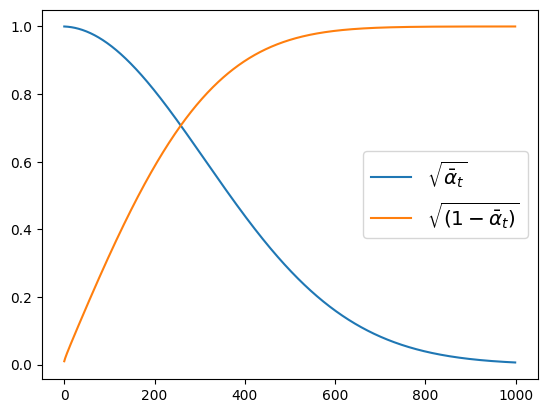

In [34]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps = 1000, clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [35]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(n_inputs, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.out = nn.Linear(64, n_outputs) 

    def forward(self, z, t, y):
        
        # Concatenate z, t, and y along the feature dimension (dim=1)
        x = torch.cat([z, t, y], dim=1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.out(x)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [36]:
#тут немного GPT подсобил
def generate_with_diffusion(model, y, latent_dim, scheduler):

    model.eval()
    
    num_timesteps = scheduler.config.num_train_timesteps
    timesteps = reversed(range(num_timesteps))
    
    batch_size = y.shape[0]
    
    X_fake = torch.randn((batch_size, latent_dim), device=DEVICE)
    
    for t in timesteps: 
        t_tensor = torch.full((batch_size,), t, device=DEVICE, dtype=torch.long).unsqueeze(1)
    
        with torch.no_grad():
            
            noise_pred = model(X_fake, t_tensor, y)
                      
            X_fake = scheduler.step(noise_pred, t, X_fake).prev_sample
      
    return X_fake.detach().cpu().numpy() # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [37]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        scheduler,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.loss_fn = nn.MSELoss()
        self.opt_gen = torch.optim.AdamW(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit Diffusion
        for epoch in tqdm(range(self.n_epochs)):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                batch_size = real_batch.shape[0]

                #делаем шум
                Z_noise = torch.randn_like(real_batch).to(DEVICE)

                #генерим t
                t = torch.randint(0, self.scheduler.config.num_train_timesteps, (batch_size,), device=DEVICE).long().unsqueeze(1)

                #жеска шумим
                real_batch_noised = self.scheduler.add_noise(real_batch, Z_noise, t)

                
                #предикт
                preds = self.model(real_batch_noised, t, cond_batch)
                
                loss = self.loss_fn(preds, Z_noise)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()


            self.loss_history.append(loss_epoch)


            with torch.no_grad():
                X_sample_real = X_real[torch.randperm(X_real.size(0))[:1000]]
                y_sample_real = y_cond[:1000]
                X_sample_fake = generate_with_diffusion(self.model, y_sample_real, self.latent_dim, self.scheduler)
                y_sample_fake = y_sample_real
                
                other_agent_score(X_sample_real.detach().cpu().numpy(), y_sample_real.detach().cpu().numpy(), X_sample_fake, y_sample_fake.detach().cpu().numpy())

        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов. 

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [38]:
%%time
seed_everything(42)
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1] + 1, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0003,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

Linear regression score: 0.964
Boosting score: 0.988
Linear regression score: 0.84
Boosting score: 0.89
Linear regression score: 0.822
Boosting score: 0.85
Linear regression score: 0.816
Boosting score: 0.846
Linear regression score: 0.68
Boosting score: 0.764
Linear regression score: 0.744
Boosting score: 0.8
Linear regression score: 0.81
Boosting score: 0.85
Linear regression score: 0.778
Boosting score: 0.81
Linear regression score: 0.712
Boosting score: 0.784
Linear regression score: 0.784
Boosting score: 0.83
Linear regression score: 0.658
Boosting score: 0.764
Linear regression score: 0.84
Boosting score: 0.838
Linear regression score: 0.768
Boosting score: 0.804
Linear regression score: 0.742
Boosting score: 0.772
Linear regression score: 0.734
Boosting score: 0.758
Linear regression score: 0.758
Boosting score: 0.79
Linear regression score: 0.742
Boosting score: 0.754
Linear regression score: 0.798
Boosting score: 0.794
Linear regression score: 0.666
Boosting score: 0.744
Linea

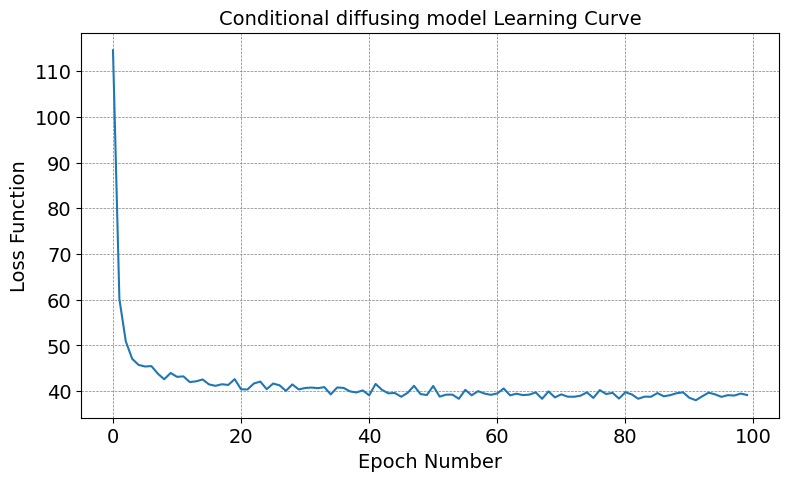

In [39]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [40]:
X_fake_train = generate_with_diffusion(
    diffusionFitter.model,
    torch.tensor(y_train, dtype=torch.float, device=DEVICE),
    latent_dim,
    diffusionFitter.scheduler,
)

X_train = quantile_transformer.inverse_transform(X_train)
X_fake_train = quantile_transformer.inverse_transform(X_fake_train)

In [41]:
X_fake_test = generate_with_diffusion(
    diffusionFitter.model,
    torch.tensor(y_test, dtype=torch.float, device=DEVICE),
    latent_dim,
    diffusionFitter.scheduler,
)

X_test = quantile_transformer.inverse_transform(X_test)
X_fake_test = quantile_transformer.inverse_transform(X_fake_test)

In [42]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [43]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_test_pred = clf.predict(XX_test)

In [44]:
auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_pred)
print("Diffusion ROC AUC  = ", auc)
print("Diffusion Accuracy = ", acc)

Diffusion ROC AUC  =  0.7486953021944911
Diffusion Accuracy =  0.6805993690851735


Получилось примерно одинаково, но я особо тоже ничего не тюнил, очевидно качество можно получше выбить, если посидеть потыкать параметры.
Я просто накинул узлов, заменил оптимизатор и, как завещал Карпатый, сделал lr=3e-4.

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ. 

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [45]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.enc_net = ...

        self.mu = ...
        self.log_sigma = ...
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.dec_net = ...
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec
    
def generate(decoder, y, latent_dim):
    ### YOUR CODE IS HERE ######
    X_fake = ...
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

In [46]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        ### YOUR CODE IS HERE ######
        loss = ...
        ### THE END OF YOUR CODE ###

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

В целом дзшка изи, надо просто делать не в последний день :D